### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes, and make a legend, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

# BCI-IL WS 2018/2019 - Exercise Sheet #10

#### Name:

In [1]:
% matplotlib inline

import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

import bci_minitoolbox as bci
import bci_classifiers as cfy

## Preparation: Load data
*Note: As SSD and TDSEP are independent of labels, the markers are obsolete for the actual tasks, but you can use them to plot results for the different classes in the end if you want.*

In [2]:
fname = 'relaxVPis.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)
#Loading error acording to forum
cnt = cnt.T

## Exercise 1: SSD decomposition (6 points)
Implement a function SSD that performs a SSD decomposition of continuous EEG data for a given central and two flanking frequency bands. Design a butterworth band-pass filter of order N=*filterorder* with the frequency *center_band* (function `sp.signal.butter`) for the central fequency band and design similarly two sets of band-pass filters  of the same order for the flanking frequency bands *flank1_band* and *flank2_band*.
The function's output should be: $\bf W$ and $\bf A$ containing the filters and patterns in their columns, respectively, $\bf D$ is a diagonal matrix with the eigenvalues of the filters on the diagonal and $\bf Y$ is the data projected on the filters.

In [3]:
def train_SSD(cnt, center_band, flank1_band, flank2_band, filterorder, fs):
    ''' Usage: W, A, D, Y = trainSSD(cnt, center_band, flank1_band, flank2_band, filterorder, fs) '''
    
    ws = fs*2*np.pi
    #Half the filterorder as described in part 3 of this exercise
    filterorder = np.round(filterorder/2)
    #Center band
    band_center = [((center_band[0]*2*np.pi)/(.5*ws)), ((center_band[1]*2*np.pi)/(.5*ws))]
    b_center, a_center = sp.signal.butter(filterorder, band_center, btype="bandpass")
    Xf_center = sp.signal.lfilter(b_center,a_center,cnt)
    #Flank1 band
    band_flank1 = [((flank1_band[0]*2*np.pi)/(.5*ws)), ((flank1_band[1]*2*np.pi)/(.5*ws))]
    b_flank1, a_flank1 = sp.signal.butter(filterorder, band_flank1, btype="bandpass")
    Xf_flank1 = sp.signal.lfilter(b_flank1,a_flank1,cnt)
    #Flank2 band
    band_flank2 = [((flank2_band[0]*2*np.pi)/(.5*ws)), ((flank2_band[1]*2*np.pi)/(.5*ws))]
    b_flank2, a_flank2 = sp.signal.butter(filterorder, band_flank2, btype="bandpass")
    Xf_flank2 = sp.signal.lfilter(b_flank2,a_flank2,cnt)
    
    #Cov
    Sigma_f = np.cov(Xf_center)
    Sigma_noise = 1/2*((np.cov(Xf_flank1) + np.cov(Xf_flank2)))
    
    d, W = sp.linalg.eigh(Sigma_f, Sigma_noise)
    
    Y = W.T.dot(cnt)
    
    D = np.identity(d.shape[0])*d
    
    A = np.dot(np.dot(Sigma_f,W),np.linalg.inv(np.cov(Y)))
    
    return W, A, D, Y
    

## Exercise 2 : TDSEP demixing (6 points)
Implement a function TDSEP that performs a TDSEP demixing on continuous EEG data, using the implementation for *two* time lags, as presented in the lecture. Output is the same as for the function SSD: $\bf W$ and $\bf A$ containing the filters and patterns in their columns, respectively, $\bf D$ is a diagonal matrix with the eigenvalues of the filters on the diagonal and $\bf Y$ is the data projected on the filters.

In [5]:
def train_TDSEP(cnt):
    ''' Usage: W, A, D, Y= train_TDSEP(cnt) '''
    lags = [0, 1]
    
    print(cnt.shape)
    
    #Time lagged covariance matrix, lecture 11 slide 8
    #Sigma_0 = 1/2*(cnt*cnt.T + cnt*cnt.T)
    Sigma_0 = 1/2*(np.matmul(cnt,cnt.T)+np.matmul(cnt,cnt.T))
    Sigma_0 = Sigma_0/(cnt.shape[1]-lags[0]*fs-1)
    
    #Delay the cnt signal by 1s? 
    delay = lags[1]*fs
    cnt_delay = cnt[:,delay:]
    #Shorten the original signal in order to multiply them
    cnt_orig = cnt[:,:cnt_delay.shape[1]]
    
    Sigma_1 = 1/2*(np.matmul(cnt_orig,cnt_delay.T)+np.matmul(cnt_delay,cnt_orig.T))
    Sigma_1 = Sigma_1 /(cnt_orig.shape[1]-lags[1]*fs-1)
    
    d, W = sp.linalg.eigh(Sigma_0, Sigma_1)
    
    Y = W.T.dot(cnt)
    
    D = np.identity(d.shape[0])*d

    A = np.dot(np.dot(Sigma_0,W),np.linalg.inv(np.cov(Y))) 
    
    return W, A, D, Y

## Exercise 3: Validation (3 points)
Run the two algorithms on the data set.
For SSD, use 11-15 Hz for the central frequency band, 8-10 Hz and 16-18 Hz for the *two* flanking frequency bands with a filter order of *N=5*.
For TDSEP use [0 1] as the two time lags and preprocess the data before with a 1 Hz butterworth *high-pass* filter of order 5. 
For both methods, visualize the filter, pattern and projected data corresponding to the two smallest and the two largest Eigenvalues.

*Note: The actual digital filter order will be 10 for a bandpass with N=5. This is due to the fact that N is filter theoretic depicting the slope in the stop bands: a band-pass is a combined high and low-pass filter leading to the double digital order.*

Text(32.3,0.5,'A [uV]')

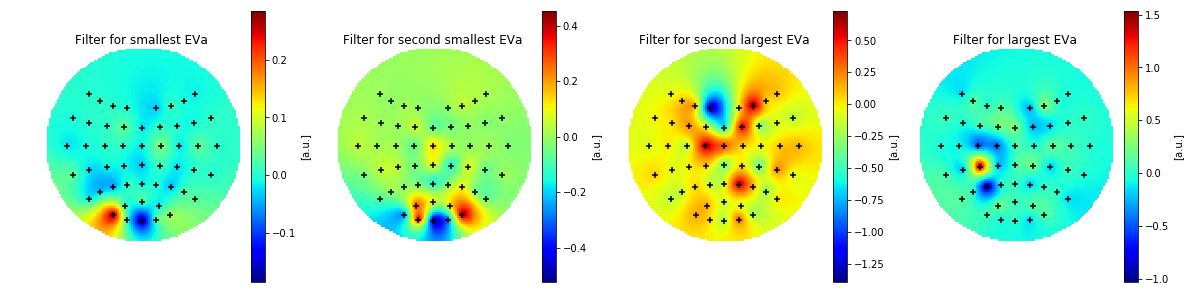

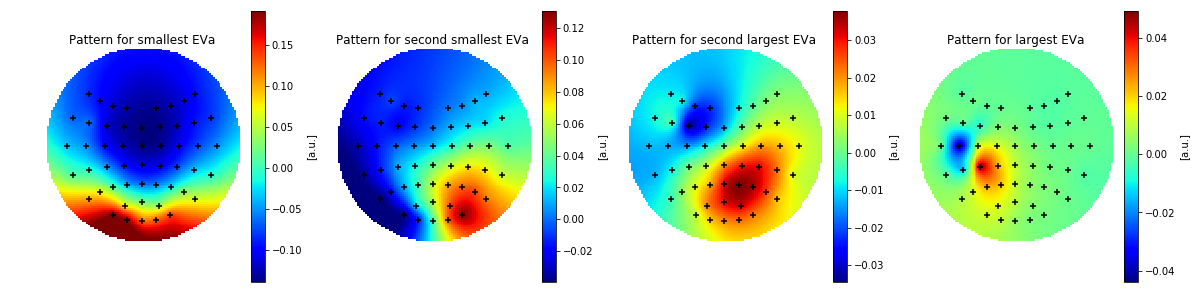

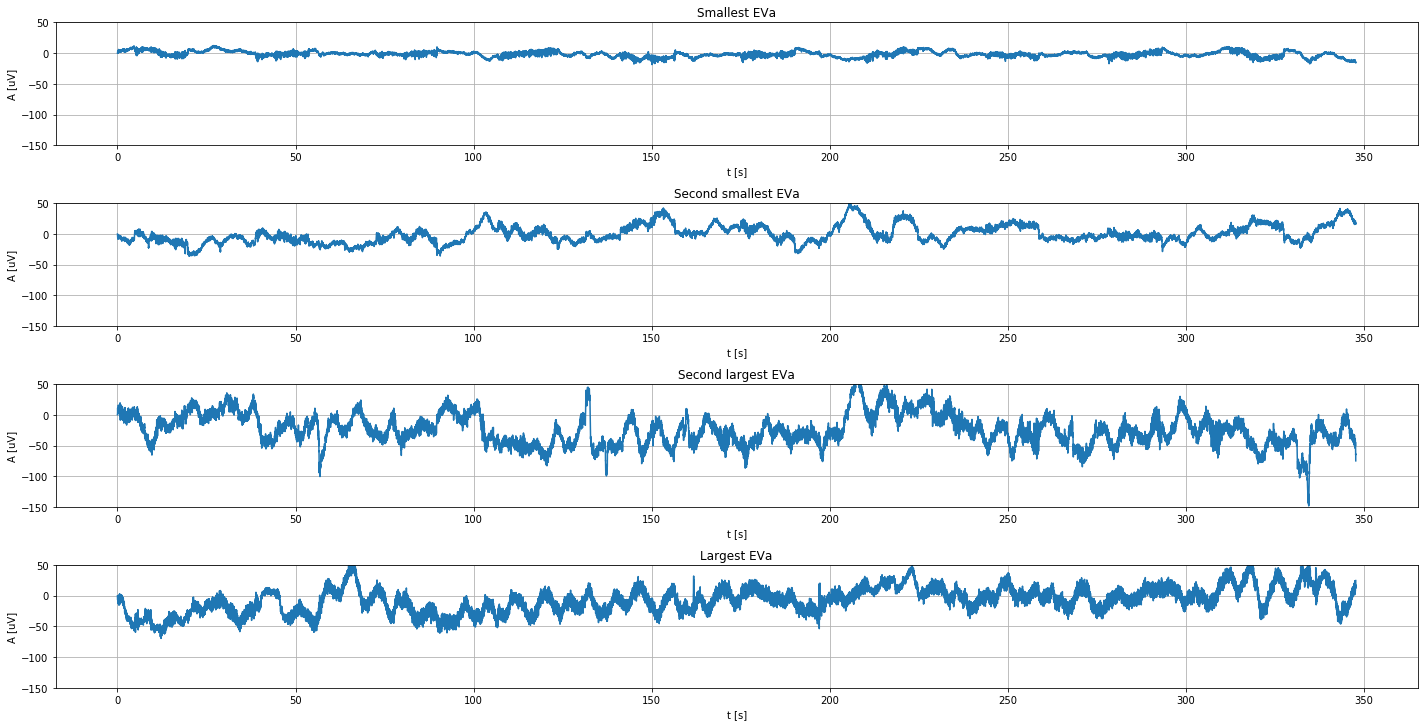

In [6]:
#SSD
W_SSD, A_SSD, D_SSD, Y_SSD = train_SSD(cnt, center_band = [11,15], flank1_band=[8,10], flank2_band=[16,18], filterorder=5, fs=fs)

###Filter 
plt.figure(figsize=(20, 10))
plt.subplot(1,4,1)
bci.scalpmap(mnt, W_SSD[:,0], cb_label='[a.u.]')
plt.title("Filter for smallest EVa")

plt.subplot(1,4,2)
bci.scalpmap(mnt, W_SSD[:,1], cb_label='[a.u.]')
plt.title("Filter for second smallest EVa")

plt.subplot(1,4,3)
bci.scalpmap(mnt, W_SSD[:,-2], cb_label='[a.u.]')
plt.title("Filter for second largest EVa")

plt.subplot(1,4,4)
bci.scalpmap(mnt, W_SSD[:,-1], cb_label='[a.u.]')
plt.title("Filter for largest EVa")

###Patterns
plt.figure(figsize=(20, 10))
plt.subplot(1,4,1)
bci.scalpmap(mnt, A_SSD[:,0], cb_label='[a.u.]')
plt.title("Pattern for smallest EVa")

plt.subplot(1,4,2)
bci.scalpmap(mnt, A_SSD[:,1], cb_label='[a.u.]')
plt.title("Pattern for second smallest EVa")

plt.subplot(1,4,3)
bci.scalpmap(mnt, A_SSD[:,-2], cb_label='[a.u.]')
plt.title("Pattern for second largest EVa")

plt.subplot(1,4,4)
bci.scalpmap(mnt, A_SSD[:,-1], cb_label='[a.u.]')
plt.title("Pattern for largest EVa")

###Projected data
#time vector
x = np.linspace(0,cnt.shape[1]/fs, cnt.shape[1])
plt.figure(figsize=(20, 10))

plt.subplot(4,1,1)
plt.tight_layout()
plt.plot(x, Y_SSD[0,:], label="Smallest EVa")
plt.grid()
plt.title("Smallest EVa")
plt.ylim([-150,50])
plt.xlabel("t [s]")
plt.ylabel("A [uV]")

plt.subplot(4,1,2)
plt.tight_layout()
plt.plot(x,Y_SSD[1,:], label="Second smallest EVa")
plt.grid()
plt.title("Second smallest EVa")
plt.ylim([-150,50])
plt.xlabel("t [s]")
plt.ylabel("A [uV]")

plt.subplot(4,1,3)
plt.tight_layout()
plt.plot(x, Y_SSD[-2,:], label="Second largest EVa")
plt.grid()
plt.title("Second largest EVa")
plt.ylim([-150,50])
plt.xlabel("t [s]")
plt.ylabel("A [uV]")

plt.subplot(4,1,4)
plt.tight_layout()
plt.plot(x, Y_SSD[-1,:], label="Largest EVa")
plt.grid()
plt.title("Largest EVa")
plt.ylim([-150,50])
plt.xlabel("t [s]")
plt.ylabel("A [uV]")

(52, 34780)
Sigma_0 shape: (52, 52)
Pos def: True
Sigma_1 shape: (52, 52)
Pos def: True
EVa Sigma_1 [  8.17821919e+04   1.48238794e+04   6.06309729e+03   1.56110016e+03
   8.14445912e+02   7.22302681e+02   5.39667815e+02   4.76182551e+02
   3.82426446e+02   3.27933659e+02   3.12269146e+02   2.58008372e+02
   2.11766427e+02   2.01639025e+02   1.69345899e+02   1.64193835e+02
   1.30841787e+02   1.25413863e+02   1.11836443e+02   9.45336254e+01
   8.59704963e+01   8.18882709e+01   7.67582107e+01   6.75220544e+01
   5.61051401e+01   5.22368063e+01   4.79180146e+01   4.47257653e+01
   3.92216276e+01   3.46594165e+01   3.30090163e+01   3.18129388e+01
   2.82465713e+01   2.54124664e+01   2.24024823e+01   2.08712923e+01
   1.66703122e+01   1.56563246e+01   1.43547991e+01   9.28257993e-01
   1.16654937e+01   1.12390982e+01   2.04754968e+00   2.32576921e+00
   3.12442673e+00   4.33845477e+00   9.27937163e+00   5.14007545e+00
   7.91709819e+00   7.63171082e+00   5.84711877e+00   6.33803915e+00]


Text(20.925,0.5,'A [uV]')

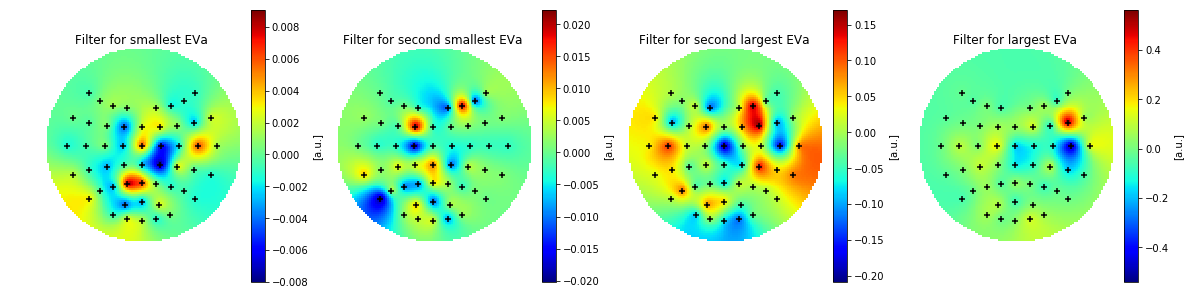

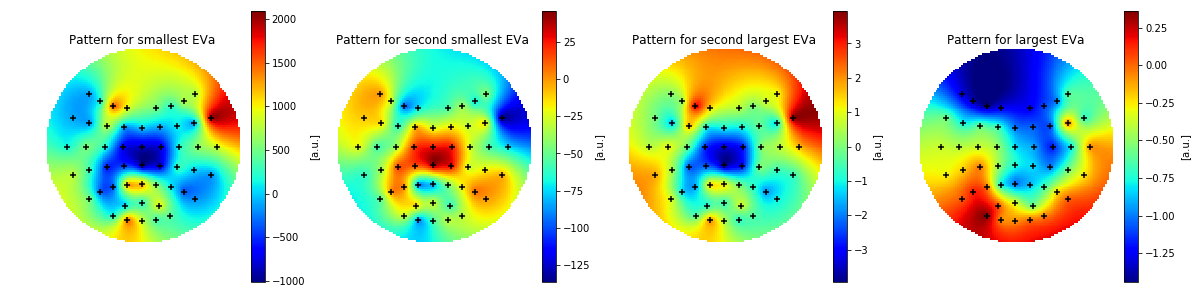

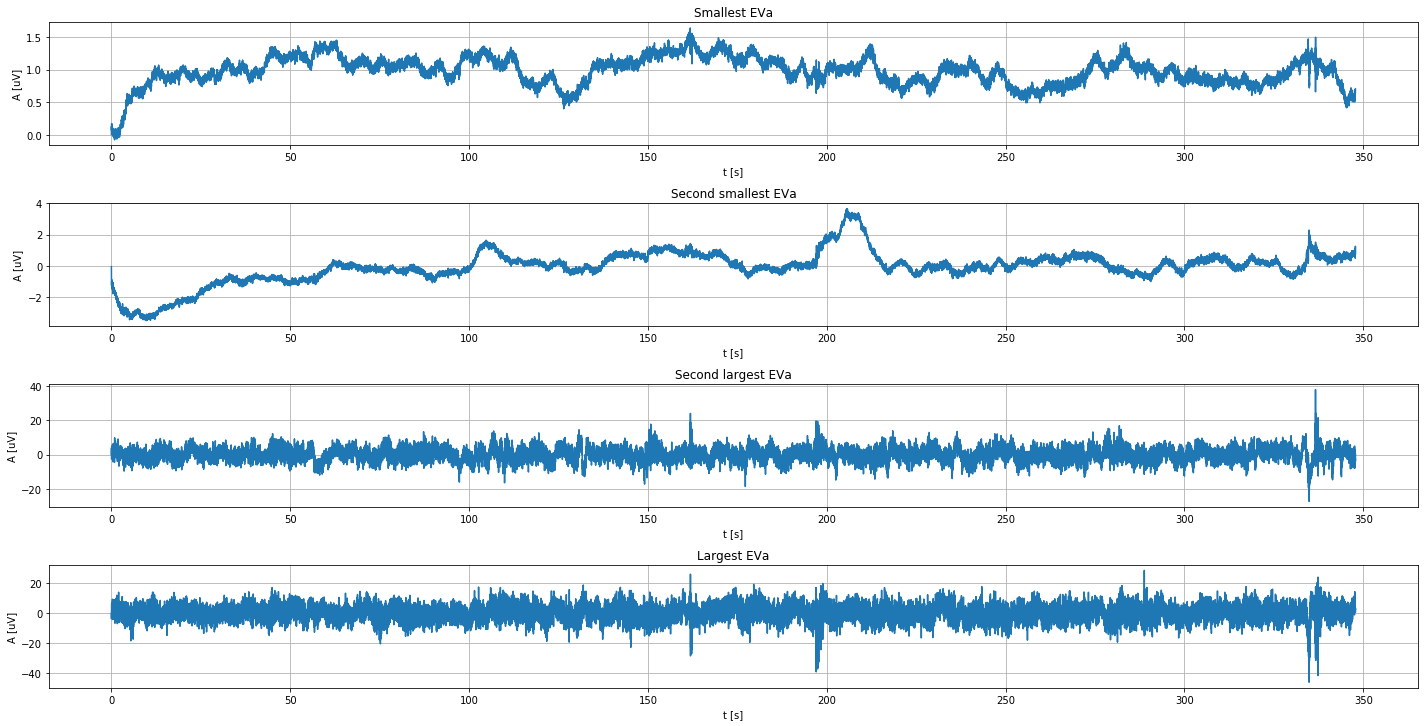

In [7]:
#TDSEP
#Preprocessing
#data before with a 0.04 Hz butterworth high-pass filter of order 5

ws = fs*2*np.pi
b, a = sp.signal.butter(5, ((0.04*2*np.pi)/(ws)),'high')
Xf = sp.signal.lfilter(b,a,cnt,axis=0)

W_TDSEP, A_TDSEP, D_TDSEP, Y_TDSEP = train_TDSEP(Xf)

###Filter 
plt.figure(figsize=(20, 10))
plt.subplot(1,4,1)
bci.scalpmap(mnt, W_TDSEP[:,0], cb_label='[a.u.]')
plt.title("Filter for smallest EVa")

plt.subplot(1,4,2)
bci.scalpmap(mnt, W_TDSEP[:,1], cb_label='[a.u.]')
plt.title("Filter for second smallest EVa")

plt.subplot(1,4,3)
bci.scalpmap(mnt, W_TDSEP[:,-2], cb_label='[a.u.]')
plt.title("Filter for second largest EVa")

plt.subplot(1,4,4)
bci.scalpmap(mnt, W_TDSEP[:,-1], cb_label='[a.u.]')
plt.title("Filter for largest EVa")

###Patterns
plt.figure(figsize=(20, 10))
plt.subplot(1,4,1)
bci.scalpmap(mnt, A_TDSEP[:,0], cb_label='[a.u.]')
plt.title("Pattern for smallest EVa")

plt.subplot(1,4,2)
bci.scalpmap(mnt, A_TDSEP[:,1], cb_label='[a.u.]')
plt.title("Pattern for second smallest EVa")

plt.subplot(1,4,3)
bci.scalpmap(mnt, A_TDSEP[:,-2], cb_label='[a.u.]')
plt.title("Pattern for second largest EVa")

plt.subplot(1,4,4)
bci.scalpmap(mnt, A_TDSEP[:,-1], cb_label='[a.u.]')
plt.title("Pattern for largest EVa")

###Projected data
plt.figure(figsize=(20, 10))

plt.subplot(4,1,1)
plt.tight_layout()
plt.plot(x, Y_TDSEP[0,:], label="Smallest EVa")
plt.grid()
plt.title("Smallest EVa")
plt.xlabel("t [s]")
plt.ylabel("A [uV]")

plt.subplot(4,1,2)
plt.tight_layout()
plt.plot(x,Y_TDSEP[1,:], label="Second smallest EVa")
plt.grid()
plt.title("Second smallest EVa")
plt.xlabel("t [s]")
plt.ylabel("A [uV]")

plt.subplot(4,1,3)
plt.tight_layout()
plt.plot(x, Y_TDSEP[-2,:], label="Second largest EVa")
plt.grid()
plt.title("Second largest EVa")
plt.xlabel("t [s]")
plt.ylabel("A [uV]")

plt.subplot(4,1,4)
plt.tight_layout()
plt.plot(x, Y_TDSEP[-1,:], label="Largest EVa")
plt.grid()
plt.title("Largest EVa")
plt.xlabel("t [s]")
plt.ylabel("A [uV]")